In [2]:
import geopandas as gpd
import folium
import json
from tqdm import tqdm
import re
import plotly.express as px

from custom_functions.gtfs_methods import detect_direction, match_schedule_for_service_line
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import logging

logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(module)s - : Line (%(lineno)d) - %(message)s",
    level=logging.INFO,
)

/Users/mjdaoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Exporting Sample

In [2]:
sp = pd.read_pickle("data\computed\matches_EWT_delay_subsampled.pkl")
sp.shape

(9300, 40)

In [3]:
sp.head()

,trip_id,theoretical_time,stop_id,stop_sequence,stop_name,route_id,service_id,trip_headsign,direction_id,route_short_name,route_long_name,th_time_sec,headway_th,clusters,cluster_agg_value,regularity,start_date_ft,end_date_ft,date_normalized,dist_m,date,time,distance_from_point,stop_id_cleaned,stop_id__terminus,stop_name__terminus,stop_id_cleaned__terminus,date_label,ligne_cleaned,mode,real_time_sec,adj_real_time,vehicule_id,approx_rec,headway_real,SWT,AWT,EWT,delay,delay_label
3755153,112949632236270000,23:08:53,8011,14,DE BROUCKERE,1,236270000,ERASME,1,1,ERASME - HERRMANN-DEBROUX,83333,10.000000,cluster_4,10.00,1,2021-09-01,2021-09-17,06-09-2021,588.817544,06-09-2021,23:13:06,0.0,8011,8642,ERASME,8642,workdays,1,M,83586,23:13:06,110765,NaN,10.866667,5.066431,6.599104,1.532673,253,lat
3755159,112949813236270000,05:09:07,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,18547,NaN,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,05:07:56,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,18476,05:07:56,111546,NaN,NaN,2.796185,8.242382,5.446197,-71,adv
3755163,112950843236270000,06:07:09,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22029,2.483333,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:07:20,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22304,06:11:44,113846,1.0,0.733333,2.796185,8.242382,5.446197,275,lat
3755164,112950421236270000,06:12:25,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22345,5.266667,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:11:00,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22260,06:11:00,113386,NaN,17.200000,2.796185,8.242382,5.446197,-85,adv
3755336,112952547236270000,05:56:26,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,21386,3.183333,cluster_0,4.75,1,2021-09-01,2021-09-17,08-09-2021,588.817544,08-09-2021,05:55:10,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,21310,05:55:10,113907,NaN,10.933333,2.531103,4.595001,2.063899,-76,adv


### Compute punctuality average and median

In [22]:
med = sp.groupby(by= ["stop_id", "route_id", "direction_id", "date_normalized", "clusters","delay_label"]).apply(lambda x: x["delay"].median())
avg = sp.groupby(by= ["stop_id", "route_id", "direction_id", "date_normalized", "clusters","delay_label"]).apply(lambda x: x["delay"].mean())

med.name = "delay_median"
avg.name = "delay_avg"

sp = sp.merge(
        med,
        on= ["stop_id", "route_id", "direction_id", "date_normalized", "clusters","delay_label"],
        how= 'left'
    ).merge(
        avg,
        on= ["stop_id", "route_id", "direction_id", "date_normalized", "clusters","delay_label"],
        how= 'left'
    )

In [3]:
def compute_punctuality_avg_and_mean(
    timetable: pd.DataFrame,
    stop_col: str = "stop_id",
    route_col: str = "route_id",
    direction_col: str = "direction_id",
    date_col: str = "date_normalized",
    cluster_col: str = "clusters",
    delay_col: str = "delay",
    delay_type_col: str = "delay_label") -> pd.DataFrame:

    med = timetable.groupby(by= [stop_col, route_col, direction_col, date_col, cluster_col, delay_type_col]).apply(lambda x: x[delay_col].median())
    avg = timetable.groupby(by= [stop_col, route_col, direction_col, date_col, cluster_col, delay_type_col]).apply(lambda x: x[delay_col].mean())

    med.name = "delay_median"
    avg.name = "delay_avg"

    timetable = timetable.merge(
            med,
            on= [stop_col, route_col, direction_col, date_col, cluster_col, delay_type_col],
            how= 'left'
        ).merge(
            avg,
            on= [stop_col, route_col, direction_col, date_col, cluster_col, delay_type_col],
            how= 'left'
        )
    
    return timetable

In [4]:
sp = compute_punctuality_avg_and_mean(sp)

In [12]:
sp

,trip_id,theoretical_time,stop_id,stop_sequence,stop_name,route_id,service_id,trip_headsign,direction_id,route_short_name,route_long_name,th_time_sec,headway_th,clusters,cluster_agg_value,regularity,start_date_ft,end_date_ft,date_normalized,dist_m,date,time,distance_from_point,stop_id_cleaned,stop_id__terminus,stop_name__terminus,stop_id_cleaned__terminus,date_label,ligne_cleaned,mode,real_time_sec,adj_real_time,vehicule_id,approx_rec,headway_real,SWT,AWT,EWT,delay,delay_label,delay_median,delay_avg
0,112949632236270000,23:08:53,8011,14,DE BROUCKERE,1,236270000,ERASME,1,1,ERASME - HERRMANN-DEBROUX,83333,10.000000,cluster_4,10.00,1,2021-09-01,2021-09-17,06-09-2021,588.817544,06-09-2021,23:13:06,0.0,8011,8642,ERASME,8642,workdays,1,M,83586,23:13:06,110765,NaN,10.866667,5.066431,6.599104,1.532673,253,lat,253.0,253.000000
1,112949813236270000,05:09:07,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,18547,NaN,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,05:07:56,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,18476,05:07:56,111546,NaN,NaN,2.796185,8.242382,5.446197,-71,adv,-78.0,-78.000000
2,112950843236270000,06:07:09,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22029,2.483333,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:07:20,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22304,06:11:44,113846,1.0,0.733333,2.796185,8.242382,5.446197,275,lat,275.0,275.000000
3,112950421236270000,06:12:25,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22345,5.266667,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:11:00,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22260,06:11:00,113386,NaN,17.200000,2.796185,8.242382,5.446197,-85,adv,-78.0,-78.000000
4,112952547236270000,05:56:26,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,21386,3.183333,cluster_0,4.75,1,2021-09-01,2021-09-17,08-09-2021,588.817544,08-09-2021,05:55:10,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,21310,05:55:10,113907,NaN,10.933333,2.531103,4.595001,2.063899,-76,adv,-76.0,-76.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,112949518236269500,23:21:38,8031,14,PARC,2,236269500,ERASME,1,1,GARE DE L'OUEST - STOCKEL,84098,10.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,18-09-2021,23:25:27,0.0,8031,8642,ERASME,8642,saturday,1,M,84327,23:25:27,497,NaN,11.166667,5.745127,5.820706,0.075579,229,lat,109.5,117.625000
9296,112947678236269500,23:31:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,84698,10.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,18-09-2021,23:31:40,0.0,8031,8731,GARE DE L'OUEST,8731,saturday,1,M,84700,23:31:40,307,NaN,6.216667,5.745127,5.820706,0.075579,2,nan,-11.0,-4.090909
9297,112947668236269500,23:46:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,85598,15.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,18-09-2021,23:48:46,0.0,8031,8731,GARE DE L'OUEST,8731,saturday,1,M,85726,23:48:46,287,NaN,17.100000,5.745127,5.820706,0.075579,128,lat,109.5,117.625000
9298,112947687236269500,24:06:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,86798,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,00:06:36,0.0,8031,8731,GARE DE L'OUEST,8731,sunday,1,M,86796,00:06:36,325,NaN,17.833333,5.745127,5.820706,0.075579,-2,adv,15.5,15.500000


### Punctuality Index

P1 = S1²/ht²
-> S1 = 1/I * somme de 1 à I de (actual arrival time - scheduled arrival time)²
-> ht = scheduled headway

P2 = S2²/ht²
-> S2 = 1/(I-1) * somme de 2 à I de (actual headway - scheduled headway)²

In [3]:
sp["delay_sq"] = (sp["delay"]/60)**2
sp["diff_headway"] = sp["headway_real"]-sp["cluster_agg_value"]
sp["diff_headway_sq"] = sp["diff_headway"]**2

In [45]:
P1 = sp[sp.regularity == 1].groupby(by= ["stop_id", "route_id", "direction_id", "date_normalized","clusters"]).apply(lambda x: (1-((((x["delay_sq"].sum())/x.shape[0])**2)/((x["cluster_agg_value"].iloc[0])**2)))*100)
# P2 = sp.groupby(by= ["stop_id", "route_id", "direction_id", "date_normalized","clusters"]).apply(lambda x: (1-((((x["diff_headway_sq"].sum())/(x.shape[0]))**2)/((x["cluster_agg_value"].iloc[0])**2)))*100)

P1.name = "P1"
# P2.name = "P2"

test = sp.merge(
        P1,
        on= ["stop_id", "route_id", "direction_id", "date_normalized"],
        how= 'left'
    )
    # .merge(
    #     P2,
    #     on= ["stop_id", "route_id", "direction_id", "date_normalized"],
    #     how= 'left')


test

,trip_id,theoretical_time,stop_id,stop_sequence,stop_name,route_id,service_id,trip_headsign,direction_id,route_short_name,route_long_name,th_time_sec,headway_th,clusters,cluster_agg_value,regularity,start_date_ft,end_date_ft,date_normalized,dist_m,date,time,distance_from_point,stop_id_cleaned,stop_id__terminus,stop_name__terminus,stop_id_cleaned__terminus,date_label,ligne_cleaned,mode,real_time_sec,adj_real_time,vehicule_id,approx_rec,headway_real,SWT,AWT,EWT,delay,delay_label,delay_sq,diff_headway,diff_headway_sq,P1
0,112949632236270000,23:08:53,8011,14,DE BROUCKERE,1,236270000,ERASME,1,1,ERASME - HERRMANN-DEBROUX,83333,10.000000,cluster_4,10.00,1,2021-09-01,2021-09-17,06-09-2021,588.817544,06-09-2021,23:13:06,0.0,8011,8642,ERASME,8642,workdays,1,M,83586,23:13:06,110765,NaN,10.866667,5.066431,6.599104,1.532673,253,lat,17.780278,0.866667,0.751111,-216.138278
1,112949813236270000,05:09:07,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,18547,NaN,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,05:07:56,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,18476,05:07:56,111546,NaN,NaN,2.796185,8.242382,5.446197,-71,adv,1.400278,NaN,NaN,-193.531072
2,112950843236270000,06:07:09,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22029,2.483333,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:07:20,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22304,06:11:44,113846,1.0,0.733333,2.796185,8.242382,5.446197,275,lat,21.006944,-4.016667,16.133611,-193.531072
3,112950421236270000,06:12:25,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22345,5.266667,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:11:00,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22260,06:11:00,113386,NaN,17.200000,2.796185,8.242382,5.446197,-85,adv,2.006944,12.450000,155.002500,-193.531072
4,112952547236270000,05:56:26,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,21386,3.183333,cluster_0,4.75,1,2021-09-01,2021-09-17,08-09-2021,588.817544,08-09-2021,05:55:10,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,21310,05:55:10,113907,NaN,10.933333,2.531103,4.595001,2.063899,-76,adv,1.604444,6.183333,38.233611,-22.427970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40179,112947687236269500,24:06:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,86798,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,00:06:36,0.0,8031,8731,GARE DE L'OUEST,8731,sunday,1,M,86796,00:06:36,325,NaN,17.833333,5.745127,5.820706,0.075579,-2,adv,0.001111,7.833333,61.361111,42.408915
40180,112947687236269500,24:06:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,86798,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,00:06:36,0.0,8031,8731,GARE DE L'OUEST,8731,sunday,1,M,86796,00:06:36,325,NaN,17.833333,5.745127,5.820706,0.075579,-2,adv,0.001111,7.833333,61.361111,92.078902
40181,112947722236269500,24:26:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,87998,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,00:27:11,0.0,8031,8731,GARE DE L'OUEST,8731,sunday,1,M,88031,00:27:11,395,NaN,20.583333,5.745127,5.820706,0.075579,33,adv,0.302500,10.583333,112.006944,-526.584336
40182,112947722236269500,24:26:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,87998,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,00:27:11,0.0,8031,8731,GARE DE L'OUEST,8731,sunday,1,M,88031,00:27:11,395,NaN,20.583333,5.745127,5.820706,0.075579,33,adv,0.302500,10.583333,112.006944,42.408915


In [46]:
test["P1"] = np.where((test["P1"] < 0) | (test["P1"] > 100), np.NaN, test["P1"])
test["P1"]

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
40179    42.408915
40180    92.078902
40181          NaN
40182    42.408915
40183    92.078902
Name: P1, Length: 40184, dtype: float64

In [47]:
test["P1"].count()

28000

In [56]:
P1_agg = test.groupby(by= ["route_id", "direction_id", "date_normalized"]).apply(lambda x: x[x.P1 != np.NaN].P1.median())
P1_agg.name = "P1_agg"

test1 = test.merge(
    P1_agg,
    on= ["route_id", "direction_id", "date_normalized"],
    how= "left"
)


c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\b

In [62]:
test1.P1_agg.count(), test1.P1_agg.shape[0]

(40121, 40184)

In [65]:
P1_agg_v2 = test.groupby(by= ["route_id", "direction_id", "date_normalized"]).apply(lambda x: x.P1.median())
P1_agg_v2.name = "P1_agg_v2"

test2 = test.merge(
    P1_agg_v2,
    on= ["route_id", "direction_id", "date_normalized"],
    how= "left"
)



c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\b

In [66]:
test2.P1_agg_v2.count(), test2.P1_agg_v2.shape[0]

(40121, 40184)

In [67]:
test1.P1_agg.describe(), test2.P1_agg_v2.describe()

(count    40121.000000
 mean        56.959180
 std         20.999664
 min          7.232502
 25%         46.273000
 50%         55.950723
 75%         70.379270
 max         94.877602
 Name: P1_agg, dtype: float64,
 count    40121.000000
 mean        56.959180
 std         20.999664
 min          7.232502
 25%         46.273000
 50%         55.950723
 75%         70.379270
 max         94.877602
 Name: P1_agg_v2, dtype: float64)

#### Final function

In [71]:
def get_punctuality_indexes(
    timetable: pd.DataFrame,
    stop_col: str = "stop_id",
    route_col: str = "route_id",
    direction_col: str = "direction_id",
    date_col: str = "date_normalized",
    cluster_col: str = "clusters",
    delay_col: str = "delay",
    headway_th_col: str = "cluster_agg_value",
    headway_real_col: str = "headway_real",
    qos_type_col: str = "regularity"
) -> pd.DataFrame:

    timetable["delay_sq"] = (timetable[delay_col]/60)**2
    timetable["diff_headway"] = timetable[headway_real_col]-timetable[headway_th_col]
    timetable["diff_headway_sq"] = timetable["diff_headway"]**2

    P1 = timetable[timetable[qos_type_col] == 1].groupby(by= [stop_col, route_col, direction_col, date_col,cluster_col]).apply(lambda x: (1-((((x["delay_sq"].sum())/x.shape[0])**2)/((x[headway_th_col].iloc[0])**2)))*100)
    P2 = timetable[timetable[qos_type_col] == 1].groupby(by= [stop_col, route_col, direction_col, date_col,cluster_col]).apply(lambda x: (1-((((x["diff_headway_sq"].sum())/(x.shape[0]))**2)/((x[headway_th_col].iloc[0])**2)))*100)

    P1.name = "P1"
    P2.name = "P2"

    timetable = timetable.merge(
            P1,
            on= [stop_col, route_col, direction_col, date_col],
            how= 'left'
        ).merge(
            P2,
            on= [stop_col, route_col, direction_col, date_col],
            how= 'left')
    
    timetable = timetable.drop(columns= ["delay_sq", "diff_headway", "diff_headway_sq"])

    timetable["P1"] = np.where((timetable["P1"] < 0) | (timetable["P1"] > 100), np.NaN, timetable["P1"])
    timetable["P2"] = np.where((timetable["P2"] < 0) | (timetable["P2"] > 100), np.NaN, timetable["P2"])

    P1_agg = timetable.groupby(by= [route_col, direction_col, date_col]).apply(lambda x: x[x.P1 != np.NaN].P1.median())
    P2_agg = timetable.groupby(by= [route_col, direction_col, date_col]).apply(lambda x: x[x.P2 != np.NaN].P2.median())
    
    P1_agg.name = "P1_agg"
    P2_agg.name = "P2_agg"

    timetable = timetable.merge(
            P1_agg,
            on= [route_col, direction_col, date_col],
            how= "left"
        ).merge(
            P2_agg,
            on= [route_col, direction_col, date_col],
            how= "left"
        )
    
    timetable = timetable.drop(columns= ["P1", "P2"])

    return timetable

In [72]:
test = get_punctuality_indexes(sp)
test

c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\bagui\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\b

,trip_id,theoretical_time,stop_id,stop_sequence,stop_name,route_id,service_id,trip_headsign,direction_id,route_short_name,route_long_name,th_time_sec,headway_th,clusters,cluster_agg_value,regularity,start_date_ft,end_date_ft,date_normalized,dist_m,date,time,distance_from_point,stop_id_cleaned,stop_id__terminus,stop_name__terminus,stop_id_cleaned__terminus,date_label,ligne_cleaned,mode,real_time_sec,adj_real_time,vehicule_id,approx_rec,headway_real,SWT,AWT,EWT,delay,delay_label,P1_agg,P2_agg
0,112949632236270000,23:08:53,8011,14,DE BROUCKERE,1,236270000,ERASME,1,1,ERASME - HERRMANN-DEBROUX,83333,10.000000,cluster_4,10.00,1,2021-09-01,2021-09-17,06-09-2021,588.817544,06-09-2021,23:13:06,0.0,8011,8642,ERASME,8642,workdays,1,M,83586,23:13:06,110765,NaN,10.866667,5.066431,6.599104,1.532673,253,lat,NaN,99.435832
1,112949813236270000,05:09:07,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,18547,NaN,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,05:07:56,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,18476,05:07:56,111546,NaN,NaN,2.796185,8.242382,5.446197,-71,adv,NaN,NaN
2,112950843236270000,06:07:09,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22029,2.483333,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:07:20,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22304,06:11:44,113846,1.0,0.733333,2.796185,8.242382,5.446197,275,lat,NaN,NaN
3,112950421236270000,06:12:25,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22345,5.266667,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:11:00,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22260,06:11:00,113386,NaN,17.200000,2.796185,8.242382,5.446197,-85,adv,NaN,NaN
4,112952547236270000,05:56:26,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,21386,3.183333,cluster_0,4.75,1,2021-09-01,2021-09-17,08-09-2021,588.817544,08-09-2021,05:55:10,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,21310,05:55:10,113907,NaN,10.933333,2.531103,4.595001,2.063899,-76,adv,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179115,112947722236269500,24:26:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,87998,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,00:27:11,0.0,8031,8731,GARE DE L'OUEST,8731,sunday,1,M,88031,00:27:11,395,NaN,20.583333,5.745127,5.820706,0.075579,33,adv,76.549095,62.431697
179116,112947722236269500,24:26:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,87998,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,00:27:11,0.0,8031,8731,GARE DE L'OUEST,8731,sunday,1,M,88031,00:27:11,395,NaN,20.583333,5.745127,5.820706,0.075579,33,adv,76.549095,62.431697
179117,112947722236269500,24:26:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,87998,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,00:27:11,0.0,8031,8731,GARE DE L'OUEST,8731,sunday,1,M,88031,00:27:11,395,NaN,20.583333,5.745127,5.820706,0.075579,33,adv,76.549095,62.431697
179118,112947722236269500,24:26:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,87998,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,00:27:11,0.0,8031,8731,GARE DE L'OUEST,8731,sunday,1,M,88031,00:27:11,395,NaN,20.583333,5.745127,5.820706,0.075579,33,adv,76.549095,62.431697


In [74]:
test.P1_agg.describe(), test.P2_agg.describe(), test.shape[0]

(count    179035.000000
 mean         56.605601
 std          21.121329
 min           7.232502
 25%          38.963752
 50%          55.054514
 75%          70.368106
 max          94.877602
 Name: P1_agg, dtype: float64,
 count    137366.000000
 mean         44.403625
 std          27.459253
 min           4.751368
 25%          11.027624
 50%          51.301830
 75%          70.290174
 max          99.435832
 Name: P2_agg, dtype: float64,
 179120)

#### Exploration

In [42]:
groups = test.groupby(by= ["stop_id", "route_id", "direction_id", "date_normalized"])

for name,group in groups:
    print(name)
    print(group.shape)

('8011', 1, 1, '06-09-2021')
(1, 44)
('8011', 1, 1, '07-09-2021')
(3, 44)
('8011', 1, 1, '08-09-2021')
(3, 44)
('8011', 1, 1, '09-09-2021')
(4, 44)
('8011', 1, 1, '10-09-2021')
(4, 44)
('8011', 1, 1, '11-09-2021')
(1, 44)
('8011', 1, 1, '13-09-2021')
(4, 44)
('8011', 1, 1, '14-09-2021')
(3, 44)
('8011', 1, 1, '15-09-2021')
(4, 44)
('8011', 1, 1, '16-09-2021')
(10, 44)
('8011', 1, 1, '17-09-2021')
(3, 44)
('8011', 1, 1, '18-09-2021')
(1, 44)
('8011', 2, 1, '06-09-2021')
(492, 44)
('8011', 2, 1, '07-09-2021')
(825, 44)
('8011', 2, 1, '08-09-2021')
(805, 44)
('8011', 2, 1, '09-09-2021')
(835, 44)
('8011', 2, 1, '10-09-2021')
(835, 44)
('8011', 2, 1, '11-09-2021')
(472, 44)
('8011', 2, 1, '13-09-2021')
(825, 44)
('8011', 2, 1, '14-09-2021')
(830, 44)
('8011', 2, 1, '15-09-2021')
(835, 44)
('8011', 2, 1, '16-09-2021')
(840, 44)
('8011', 2, 1, '17-09-2021')
(855, 44)
('8011', 2, 1, '18-09-2021')
(492, 44)
('8012', 2, 0, '06-09-2021')
(615, 44)
('8012', 2, 0, '07-09-2021')
(830, 44)
('8012', 

<AxesSubplot: ylabel='Frequency'>

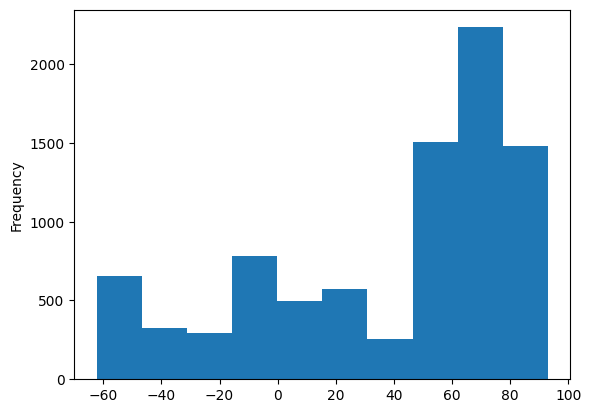

In [27]:
test[(test.P1 <= test.P1.quantile(.95)) & (test.P1.quantile(.05) <= test.P1)].P1.plot.hist()

In [20]:
test[test.P1 < test.P1.quantile(.95)]

,trip_id,theoretical_time,stop_id,stop_sequence,stop_name,route_id,service_id,trip_headsign,direction_id,route_short_name,route_long_name,th_time_sec,headway_th,clusters,cluster_agg_value,regularity,start_date_ft,end_date_ft,date_normalized,dist_m,date,time,distance_from_point,stop_id_cleaned,stop_id__terminus,stop_name__terminus,stop_id_cleaned__terminus,date_label,ligne_cleaned,mode,real_time_sec,adj_real_time,vehicule_id,approx_rec,headway_real,SWT,AWT,EWT,delay,delay_label,delay_median,delay_avg,delay_sq,diff_headway,diff_headway_sq,P1,P2
0,112949632236270000,23:08:53,8011,14,DE BROUCKERE,1,236270000,ERASME,1,1,ERASME - HERRMANN-DEBROUX,83333,10.000000,cluster_4,10.00,1,2021-09-01,2021-09-17,06-09-2021,588.817544,06-09-2021,23:13:06,0.0,8011,8642,ERASME,8642,workdays,1,M,83586,23:13:06,110765,NaN,10.866667,5.066431,6.599104,1.532673,253,lat,253.0,253.000000,17.780278,0.866667,0.751111,-216.138278,99.435832
1,112949813236270000,05:09:07,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,18547,NaN,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,05:07:56,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,18476,05:07:56,111546,NaN,NaN,2.796185,8.242382,5.446197,-71,adv,-78.0,-78.000000,1.400278,NaN,NaN,-193.531072,-14322.933100
2,112950843236270000,06:07:09,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22029,2.483333,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:07:20,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22304,06:11:44,113846,1.0,0.733333,2.796185,8.242382,5.446197,275,lat,275.0,275.000000,21.006944,-4.016667,16.133611,-193.531072,-14322.933100
3,112950421236270000,06:12:25,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22345,5.266667,cluster_0,4.75,1,2021-09-01,2021-09-17,07-09-2021,588.817544,07-09-2021,06:11:00,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22260,06:11:00,113386,NaN,17.200000,2.796185,8.242382,5.446197,-85,adv,-78.0,-78.000000,2.006944,12.450000,155.002500,-193.531072,-14322.933100
4,112952547236270000,05:56:26,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,21386,3.183333,cluster_0,4.75,1,2021-09-01,2021-09-17,08-09-2021,588.817544,08-09-2021,05:55:10,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,21310,05:55:10,113907,NaN,10.933333,2.531103,4.595001,2.063899,-76,adv,-76.0,-76.000000,1.604444,6.183333,38.233611,-22.427970,-1291.595397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,112949518236269500,23:21:38,8031,14,PARC,2,236269500,ERASME,1,1,GARE DE L'OUEST - STOCKEL,84098,10.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,18-09-2021,23:25:27,0.0,8031,8642,ERASME,8642,saturday,1,M,84327,23:25:27,497,NaN,11.166667,5.745127,5.820706,0.075579,229,lat,109.5,117.625000,14.566944,1.166667,1.361111,45.644328,-90.239771
9296,112947678236269500,23:31:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,84698,10.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,18-09-2021,23:31:40,0.0,8031,8731,GARE DE L'OUEST,8731,saturday,1,M,84700,23:31:40,307,NaN,6.216667,5.745127,5.820706,0.075579,2,nan,-11.0,-4.090909,0.001111,-3.783333,14.313611,45.644328,-90.239771
9297,112947668236269500,23:46:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,85598,15.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,18-09-2021,23:48:46,0.0,8031,8731,GARE DE L'OUEST,8731,saturday,1,M,85726,23:48:46,287,NaN,17.100000,5.745127,5.820706,0.075579,128,lat,109.5,117.625000,4.551111,7.100000,50.410000,45.644328,-90.239771
9298,112947687236269500,24:06:38,8031,14,PARC,2,236269500,GARE DE L'OUEST,1,1,GARE DE L'OUEST - STOCKEL,86798,20.000000,cluster_3,10.00,1,2021-09-04,2021-09-18,18-09-2021,471.506564,19-09-2021,0

In [21]:
test.P1.quantile(.05)

-62.1608208204103

##### test step by step

In [44]:
sample = groups.get_group(('8011', 1, 1, '08-09-2021'))
sample

,trip_id,theoretical_time,stop_id,stop_sequence,stop_name,route_id,service_id,trip_headsign,direction_id,route_short_name,route_long_name,th_time_sec,headway_th,clusters,cluster_agg_value,regularity,start_date_ft,end_date_ft,date_normalized,dist_m,date,time,distance_from_point,stop_id_cleaned,stop_id__terminus,stop_name__terminus,stop_id_cleaned__terminus,date_label,ligne_cleaned,mode,real_time_sec,adj_real_time,vehicule_id,approx_rec,headway_real,SWT,AWT,EWT,delay,delay_label,delay_sq,diff_headway,diff_headway_sq,P1
4,112952547236270000,05:56:26,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,21386,3.183333,cluster_0,4.75,1,2021-09-01,2021-09-17,08-09-2021,588.817544,08-09-2021,05:55:10,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,21310,05:55:10,113907,NaN,10.933333,2.531103,4.595001,2.063899,-76,adv,1.604444,6.183333,38.233611,NaN
5,112950843236270000,06:07:09,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22029,2.483333,cluster_0,4.75,1,2021-09-01,2021-09-17,08-09-2021,588.817544,08-09-2021,06:07:36,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22254,06:10:54,113847,1.0,7.283333,2.531103,4.595001,2.063899,225,lat,14.062500,2.533333,6.417778,NaN
6,112950421236270000,06:12:25,8011,11,DE BROUCKERE,1,236270000,GARE DE L'OUEST,1,1,ERASME - HERRMANN-DEBROUX,22345,5.266667,cluster_0,4.75,1,2021-09-01,2021-09-17,08-09-2021,588.817544,08-09-2021,06:12:44,0.0,8011,8731,GARE DE L'OUEST,8731,workdays,1,M,22364,06:12:44,113387,NaN,1.833333,2.531103,4.595001,2.063899,19,nan,0.100278,-2.916667,8.506944,NaN


In [37]:
S1 = (1/sample.shape[0])*(sample["delay_sq"].sum())
S1_sq = S1**2
ht_sq = sample["cluster_agg_value"].iloc[0]**2

S2 = (1/(sample.shape[0]))*(sample["diff_headway_sq"].sum())
S2_sq = S2**2

P1 = S1_sq/ht_sq
P2 = S2_sq/ht_sq

P1_pc = (1-P1)*100
P2_pc = (1-P2)*100

print("S1_sq :", S1_sq )
print("S1 :", S1 )
print("sample.shape[0]: ", sample.shape[0] )
print("delay_sq sum :", sample["delay_sq"].sum() )
print("S2_sq :", S2_sq )
print("S2 :", S2 )
print("diff_head_sq sum: ", sample["diff_headway_sq"].sum())
print("ht: ", sample["cluster_agg_value"].iloc[0])
print("ht_sq: ", ht_sq)
print("P1: ", P1)
print("P1_pc ", P1_pc)
print("P2: ", P2)
print("P2_pc ", P2_pc)


S1_sq : 66.22794822530864
S1 : 8.138055555555555
sample.shape[0]:  3
delay_sq sum : 24.414166666666667
S2_sq : 3254.174280692729
S2 : 57.045370370370364
diff_head_sq sum:  171.1361111111111
ht:  4.75
ht_sq:  22.5625
P1:  2.935310724667419
P1_pc  -193.53107246674188
P2:  144.22933100023175
P2_pc  -14322.933100023176


## Correction

In [6]:
def get_punctuality_indexes(
    timetable: pd.DataFrame,
    stop_col: str = "stop_id",
    route_col: str = "route_id",
    direction_col: str = "direction_id",
    service_id:str = "service_id",
    date_col: str = "date_normalized",
    cluster_col: str = "clusters",
    delay_col: str = "delay",
    headway_th_col: str = "cluster_agg_value",
    headway_real_col: str = "headway_real",
    qos_type_col: str = "regularity"
) -> pd.DataFrame:

    logging.info("Computing P1 and P2s")
    timetable["delay_sq"] = (timetable[delay_col]/60)**2
    timetable["diff_headway"] = timetable[headway_real_col]-timetable[headway_th_col]
    timetable["diff_headway_sq"] = timetable["diff_headway"]**2

    timetable["P1"] = timetable[timetable[qos_type_col] == 1].groupby(by= [stop_col, route_col, direction_col, date_col, service_id,cluster_col]).apply(lambda x: (1-((((x["delay_sq"].sum())/x.shape[0])**2)/((x[headway_th_col].iloc[0])**2)))*100)
    P2 = timetable[timetable[qos_type_col] == 1].groupby(by= [stop_col, route_col, direction_col, date_col, service_id,cluster_col]).apply(lambda x: (1-((((x["diff_headway_sq"].sum())/(x.shape[0]))**2)/((x[headway_th_col].iloc[0])**2)))*100)

    P1.name = "P1"
    P2.name = "P2"

    logging.info("Merging them in the original table")
    timetable = timetable.merge(
            P1,
            on= [stop_col, route_col, direction_col, date_col, service_id],
            how= 'left'
        ).merge(
            P2,
            on= [stop_col, route_col, direction_col, date_col, service_id],
            how= 'left')
    
    timetable = timetable.drop(columns= ["delay_sq", "diff_headway", "diff_headway_sq"])

    timetable["P1"] = np.where((timetable["P1"] < 0) | (timetable["P1"] > 100), np.NaN, timetable["P1"])
    timetable["P2"] = np.where((timetable["P2"] < 0) | (timetable["P2"] > 100), np.NaN, timetable["P2"])

    logging.info("Aggregating them to a line level")
    P1_agg = timetable.groupby(by= [route_col, direction_col, date_col, service_id]).apply(lambda x: x[x.P1 != np.NaN].P1.median())
    P2_agg = timetable.groupby(by= [route_col, direction_col, date_col, service_id]).apply(lambda x: x[x.P2 != np.NaN].P2.median())
    
    P1_agg.name = "P1_agg"
    P2_agg.name = "P2_agg"

    logging.info("Merging the line level P1/2")
    timetable = timetable.merge(
            P1_agg,
            on= [route_col, direction_col, date_col, service_id],
            how= "left"
        ).merge(
            P2_agg, 
            on= [route_col, direction_col, date_col, service_id],
            how= "left"
        )
    
    #timetable = timetable.drop(columns= ["P1", "P2"])

    return timetable

In [3]:
def get_punctuality_indexes(
    timetable: pd.DataFrame,
    stop_col: str = "stop_id",
    route_col: str = "route_id",
    direction_col: str = "direction_id",
    service_id:str = "service_id",
    date_col: str = "date_normalized",
    cluster_col: str = "clusters",
    delay_col: str = "delay",
    headway_th_col: str = "cluster_agg_value",
    headway_real_col: str = "headway_real",
    qos_type_col: str = "regularity"
) -> pd.DataFrame:

    logging.info("Computing P1 and P2s")
    timetable["delay_sq"] = (timetable[delay_col]/60)**2
    timetable["diff_headway"] = timetable[headway_real_col]-timetable[headway_th_col]
    timetable["diff_headway_sq"] = timetable["diff_headway"]**2

    P1 = timetable[timetable[qos_type_col] == 1].groupby(by= [stop_col, route_col, direction_col, date_col, service_id, cluster_col]).apply(lambda x: (1-((((x["delay_sq"].sum())/x.shape[0])**2)/((x[headway_th_col].iloc[0])**2)))*100)
    P2 = timetable[timetable[qos_type_col] == 1].groupby(by= [stop_col, route_col, direction_col, date_col, service_id, cluster_col]).apply(lambda x: (1-((((x["diff_headway_sq"].sum())/(x.shape[0]))**2)/((x[headway_th_col].iloc[0])**2)))*100)

    P1.name = "P1"
    P2.name = "P2"
        
    logging.info("Merging them in the original table")
    timetable = timetable.merge(
            P1,
            on= [stop_col, route_col, direction_col, date_col, service_id, cluster_col],
            how= 'left'
        ).merge(
            P2,
            on= [stop_col, route_col, direction_col, date_col, service_id, cluster_col],
            how= 'left')
    
    timetable = timetable.drop(columns= ["delay_sq", "diff_headway", "diff_headway_sq"])


    timetable["P1"] = np.where((timetable["P1"] < 0) | (timetable["P1"] > 100), np.NaN, timetable["P1"])
    timetable["P2"] = np.where((timetable["P2"] < 0) | (timetable["P2"] > 100), np.NaN, timetable["P2"])

    return timetable

In [4]:
res = pd.read_pickle("data/computed/matches_clean_EWT_delay.pkl")

In [5]:
PIs = get_punctuality_indexes(res)

2022-12-17 12:02:01,729 - root - INFO - 2642090508 - : Line (15) - Computing P1 and P2s
2022-12-17 12:02:22,922 - root - INFO - 2642090508 - : Line (26) - Merging them in the original table


In [16]:
PIs

,trip_id,theoretical_time,stop_id,stop_sequence,stop_name,route_id,service_id,trip_headsign,direction_id,route_short_name,route_long_name,th_time_sec,headway_th,clusters,cluster_agg_value,regularity,start_date_ft,end_date_ft,date_normalized,dist_m,distance_from_point,stop_id_cleaned,stop_id__terminus,stop_name__terminus,stop_id_cleaned__terminus,date_label,ligne_cleaned,mode,real_time_sec,adj_real_time,vehicule_id,approx_rec,headway_real,SWT,AWT,EWT,EWT_label,delay,delay_label_strict,delay_label_60,delay_label_120,hour,day,P1,P2
0,112960457236299000,05:17:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,19020,NaN,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,60.0,89,9556,TERVUREN STATION,9556,workdays,44,T,19020,05:17:00,76753,NaN,NaN,8.654762,11.624663,2.969901,irregular,0,nan,nan,nan,5,7,NaN,NaN
1,112961236236299000,05:39:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,20340,22.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,0.0,89,9556,TERVUREN STATION,9556,workdays,44,T,21136,05:52:16,79193,NaN,35.266667,8.654762,11.624663,2.969901,irregular,796,lat,lat,lat,5,7,NaN,NaN
2,112960463236299000,05:56:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,21360,17.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,101.0,89,9556,TERVUREN STATION,9556,workdays,44,T,21331,05:55:31,76783,NaN,3.250000,8.654762,11.624663,2.969901,irregular,-29,adv,nan,nan,5,7,NaN,NaN
3,112960468236299000,06:12:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,22320,16.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,0.0,89,9556,TERVUREN STATION,9556,workdays,44,T,22324,06:12:04,76813,NaN,16.550000,8.654762,11.624663,2.969901,irregular,4,nan,nan,nan,6,7,NaN,NaN
4,112960472236299000,06:28:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,23280,16.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,0.0,89,9556,TERVUREN STATION,9556,workdays,44,T,23298,06:28:18,76833,NaN,16.233333,8.654762,11.624663,2.969901,irregular,18,nan,nan,nan,6,7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434406,113242700237156051,08:01:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,28860,13.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,406.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,28778,07:59:38,91004,NaN,13.383333,6.382353,7.235564,0.853211,regular,-82,adv,adv,nan,8,17,NaN,NaN
3434407,113242701237156051,08:13:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,29580,12.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,126.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,29579,08:12:59,91014,NaN,13.350000,6.382353,7.235564,0.853211,regular,-1,adv,nan,nan,8,17,NaN,NaN
3434408,113242702237156051,08:26:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,30360,13.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,0.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,30885,08:34:45,91024,NaN,21.766667,6.382353,7.235564,0.853211,regular,525,lat,lat,lat,8,17,NaN,NaN
3434409,113242703237156051,08:38:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,31080,12.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,562.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,31166,08:39:26,91034,NaN,4.683333,6.382353,7.235564,0.853211,regular,86,lat,lat,nan,8,17,NaN,NaN


In [17]:
PIs[PIs.P1.isna()]

,trip_id,theoretical_time,stop_id,stop_sequence,stop_name,route_id,service_id,trip_headsign,direction_id,route_short_name,route_long_name,th_time_sec,headway_th,clusters,cluster_agg_value,regularity,start_date_ft,end_date_ft,date_normalized,dist_m,distance_from_point,stop_id_cleaned,stop_id__terminus,stop_name__terminus,stop_id_cleaned__terminus,date_label,ligne_cleaned,mode,real_time_sec,adj_real_time,vehicule_id,approx_rec,headway_real,SWT,AWT,EWT,EWT_label,delay,delay_label_strict,delay_label_60,delay_label_120,hour,day,P1,P2
0,112960457236299000,05:17:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,19020,NaN,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,60.0,89,9556,TERVUREN STATION,9556,workdays,44,T,19020,05:17:00,76753,NaN,NaN,8.654762,11.624663,2.969901,irregular,0,nan,nan,nan,5,7,NaN,NaN
1,112961236236299000,05:39:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,20340,22.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,0.0,89,9556,TERVUREN STATION,9556,workdays,44,T,21136,05:52:16,79193,NaN,35.266667,8.654762,11.624663,2.969901,irregular,796,lat,lat,lat,5,7,NaN,NaN
2,112960463236299000,05:56:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,21360,17.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,101.0,89,9556,TERVUREN STATION,9556,workdays,44,T,21331,05:55:31,76783,NaN,3.250000,8.654762,11.624663,2.969901,irregular,-29,adv,nan,nan,5,7,NaN,NaN
3,112960468236299000,06:12:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,22320,16.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,0.0,89,9556,TERVUREN STATION,9556,workdays,44,T,22324,06:12:04,76813,NaN,16.550000,8.654762,11.624663,2.969901,irregular,4,nan,nan,nan,6,7,NaN,NaN
4,112960472236299000,06:28:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,23280,16.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,0.0,89,9556,TERVUREN STATION,9556,workdays,44,T,23298,06:28:18,76833,NaN,16.233333,8.654762,11.624663,2.969901,irregular,18,nan,nan,nan,6,7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434406,113242700237156051,08:01:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,28860,13.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,406.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,28778,07:59:38,91004,NaN,13.383333,6.382353,7.235564,0.853211,regular,-82,adv,adv,nan,8,17,NaN,NaN
3434407,113242701237156051,08:13:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,29580,12.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,126.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,29579,08:12:59,91014,NaN,13.350000,6.382353,7.235564,0.853211,regular,-1,adv,nan,nan,8,17,NaN,NaN
3434408,113242702237156051,08:26:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,30360,13.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,0.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,30885,08:34:45,91024,NaN,21.766667,6.382353,7.235564,0.853211,regular,525,lat,lat,lat,8,17,NaN,NaN
3434409,113242703237156051,08:38:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,31080,12.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,562.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,31166,08:39:26,91034,NaN,4.683333,6.382353,7.235564,0.853211,regular,86,lat,lat,nan,8,17,NaN,NaN


In [6]:
PIs[PIs.P2.isna()]

,trip_id,theoretical_time,stop_id,stop_sequence,stop_name,route_id,service_id,trip_headsign,direction_id,route_short_name,route_long_name,th_time_sec,headway_th,clusters,cluster_agg_value,regularity,start_date_ft,end_date_ft,date_normalized,dist_m,distance_from_point,stop_id_cleaned,stop_id__terminus,stop_name__terminus,stop_id_cleaned__terminus,date_label,ligne_cleaned,mode,real_time_sec,adj_real_time,vehicule_id,approx_rec,headway_real,SWT,AWT,EWT,EWT_label,delay,delay_label_strict,delay_label_60,delay_label_120,hour,day,P1,P2
0,112960457236299000,05:17:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,19020,NaN,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,60.0,89,9556,TERVUREN STATION,9556,workdays,44,T,19020,05:17:00,76753,NaN,NaN,8.654762,11.624663,2.969901,irregular,0,nan,nan,nan,5,7,NaN,NaN
1,112961236236299000,05:39:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,20340,22.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,0.0,89,9556,TERVUREN STATION,9556,workdays,44,T,21136,05:52:16,79193,NaN,35.266667,8.654762,11.624663,2.969901,irregular,796,lat,lat,lat,5,7,NaN,NaN
2,112960463236299000,05:56:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,21360,17.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,101.0,89,9556,TERVUREN STATION,9556,workdays,44,T,21331,05:55:31,76783,NaN,3.250000,8.654762,11.624663,2.969901,irregular,-29,adv,nan,nan,5,7,NaN,NaN
3,112960468236299000,06:12:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,22320,16.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,0.0,89,9556,TERVUREN STATION,9556,workdays,44,T,22324,06:12:04,76813,NaN,16.550000,8.654762,11.624663,2.969901,irregular,4,nan,nan,nan,6,7,NaN,NaN
4,112960472236299000,06:28:00,0089,1,MONTGOMERY,40,236299000,TERVUREN STATION,0,44,MONTGOMERY - TERVUREN STATION,23280,16.0,cluster_0,16.0,0,2021-09-01,2021-09-17,07-09-2021,NaN,0.0,89,9556,TERVUREN STATION,9556,workdays,44,T,23298,06:28:18,76833,NaN,16.233333,8.654762,11.624663,2.969901,irregular,18,nan,nan,nan,6,7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434406,113242700237156051,08:01:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,28860,13.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,406.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,28778,07:59:38,91004,NaN,13.383333,6.382353,7.235564,0.853211,regular,-82,adv,adv,nan,8,17,NaN,NaN
3434407,113242701237156051,08:13:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,29580,12.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,126.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,29579,08:12:59,91014,NaN,13.350000,6.382353,7.235564,0.853211,regular,-1,adv,nan,nan,8,17,NaN,NaN
3434408,113242702237156051,08:26:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,30360,13.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,0.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,30885,08:34:45,91024,NaN,21.766667,6.382353,7.235564,0.853211,regular,525,lat,lat,lat,8,17,NaN,NaN
3434409,113242703237156051,08:38:00,9979B,1,BARA,30,237156051,MOORTEBEEK,1,46,MOORTEBEEK - GLIBERT,31080,12.0,cluster_0,13.0,0,2021-09-03,2021-09-17,17-09-2021,NaN,562.0,9979,1201,MOORTEBEEK,1201,workdays,46,B,31166,08:39:26,91034,NaN,4.683333,6.382353,7.235564,0.853211,regular,86,lat,lat,nan,8,17,NaN,NaN
